# Code File for Plotting of the Meteorological Data

The data is generated from Meteonorm, providing an average weather for the location between 1990 and 2010.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Import data from .dat file
Generated from Meteonorm

In [2]:
# Load data
file_path = 'Data_files/bolgatanga_data.dat'
df = pd.read_csv(file_path, sep=',', skipinitialspace=True)

# Parse datetime and create season labels
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['season'] = df['month'].apply(lambda x: 'Rainy' if 5 <= x <= 10 else 'Dry')

# Calculations:
Calculate the average temperature, rainfall, and sunshine hours for the two seasons

In [3]:
# Rainfall data collected online at: https://gjstd.org/index.php/GJSTD/article/view/168 
rainfall_mm = [0.19, 2.06, 15.86, 41.76, 109.87, 132.89, 170.80, 248.71, 176.77, 61.35, 4.24, 2.52]

# Add the rainfall to the DataFrame for alignment
df['rainfall'] = df['month'].apply(lambda x: rainfall_mm[x - 1])  # Match rainfall to months

# Define rainy and dry season masks
rainy_season = df['month'].between(5, 10)  # May to October
dry_season = ~rainy_season  # All other months

# Calculate averages for rainy and dry seasons
rainy_avg_temp = df.loc[rainy_season, 'temp'].mean() # Average temp. rainy season
dry_avg_temp = df.loc[dry_season, 'temp'].mean() # Average temp. dry season 
dry_temp_max = df.loc[dry_season, 'temp'].max() # Max temp. dry season
rainy_avg_rainfall = df.loc[rainy_season, 'rainfall'].mean() # Average rainfall rainy season
dry_avg_rainfall = df.loc[dry_season, 'rainfall'].mean() # Average rainfall dry season
rainy_avg_sun_hours = df.loc[rainy_season, 'sunshine_duration'].mean() # Average sunshine duration rainy season
dry_avg_sun_hours = df.loc[dry_season, 'sunshine_duration'].mean() # Average sunshine duration dry season

# Display the results:
print("Rainy Season:")
print(f"- Avg. Temperature: {rainy_avg_temp:.2f}°C")
print(f"- Avg. Rainfall: {rainy_avg_rainfall:.2f} mm")
print(f"- Avg. Sun Hours: {rainy_avg_sun_hours:.2f} hours")

print("\nDry Season:")
print(f"- Avg. Temperature: {dry_avg_temp:.2f}°C")
print(f"- Avg. Rainfall: {dry_avg_rainfall:.2f} mm")
print(f"- Avg. Sun Hours: {dry_avg_sun_hours:.2f} hours")
print(f"\nHighest temp:{dry_temp_max:.2f}")

Rainy Season:
- Avg. Temperature: 28.64°C
- Avg. Rainfall: 150.01 mm
- Avg. Sun Hours: 16.85 hours

Dry Season:
- Avg. Temperature: 29.12°C
- Avg. Rainfall: 11.12 mm
- Avg. Sun Hours: 21.57 hours

Highest temp:43.00


Calculations of the days with low solar radiation during rainy season:

In [4]:
# Load data
df['rainy_season'] = df['month'].between(5, 10)

# Filter data for rainy season and group by day
rainy_season_data = df[df['rainy_season']].copy()
#daily_production = rainy_season_data.groupby(df['date'].dt.date)['PV_prod'].sum()
daily_production = rainy_season_data.groupby(df['date'].dt.date)['GRH'].sum()

# Identify days with zero production
low_production_days = daily_production[daily_production < 1000]

# Count total number of zero-production days
total_zero_days = len(low_production_days)

# Find streaks of consecutive zero-production days
zero_streaks = (low_production_days.index.to_series().diff() != pd.Timedelta(days=1)).cumsum()
longest_streak = zero_streaks.value_counts().max()

# Results
print(f"Total days with radiation less than 1000 W/m^2 during the rainy season: {total_zero_days}")
print(f"Longest streak of consecutive days with low radiation during the rainy season : {longest_streak} days")
print(f"Day(s) with production less than 1000 W/m^2 during the rainy season: {low_production_days}")


Total days with radiation less than 1000 W/m^2 during the rainy season: 0
Longest streak of consecutive days with low radiation during the rainy season : nan days
Day(s) with production less than 1000 W/m^2 during the rainy season: Series([], Name: GRH, dtype: int64)


Calculation of days with low sunshine duration:

In [5]:
# Aggregate daily sunshine duration
sun_hours_daily = df.groupby(df['date'].dt.date)['sunshine_duration'].sum()

# Find the day with the lowest sunshine hours
lowest_sun_hours_day = sun_hours_daily.idxmin()
lowest_sun_hours_value = sun_hours_daily.min()

print(f"The day with the lowest sunshine duration: {lowest_sun_hours_day}")
print(f"The number of sunshine hours: {lowest_sun_hours_value}")

The day with the lowest sunshine duration: 2005-09-01
The number of sunshine hours: 0


Calculation of days with low radiation annually:

In [6]:
# Aggregate daily global radiation
daily_radiation = df.groupby(df['date'].dt.date)['GRH'].sum()
lowest_radiation_day = daily_radiation.idxmin()

# Set a threshold for low production (e.g., < 1 kWh/m²/day)
low_radiation_days = daily_radiation[daily_radiation < 1000]  # 1000 Wh = 1 kWh

# Count total number of low-radiation days
total_low_radiation_days = len(low_radiation_days)

# Find consecutive low-radiation streaks
low_radiation_streaks = (low_radiation_days.index.to_series().diff() != pd.Timedelta(days=1)).cumsum()
longest_low_radiation_streak = low_radiation_streaks.value_counts().max()

# Results
print(f"Total days with low radiation: {total_low_radiation_days}")
print(f"Longest streak of low-radiation days: {longest_low_radiation_streak} days")
print(f"The day with the lowest radiation: {lowest_radiation_day}")

Total days with low radiation: 1
Longest streak of low-radiation days: 1 days
The day with the lowest radiation: 2006-01-01


# Plot section:
Plot of the monthly climatology for the region 

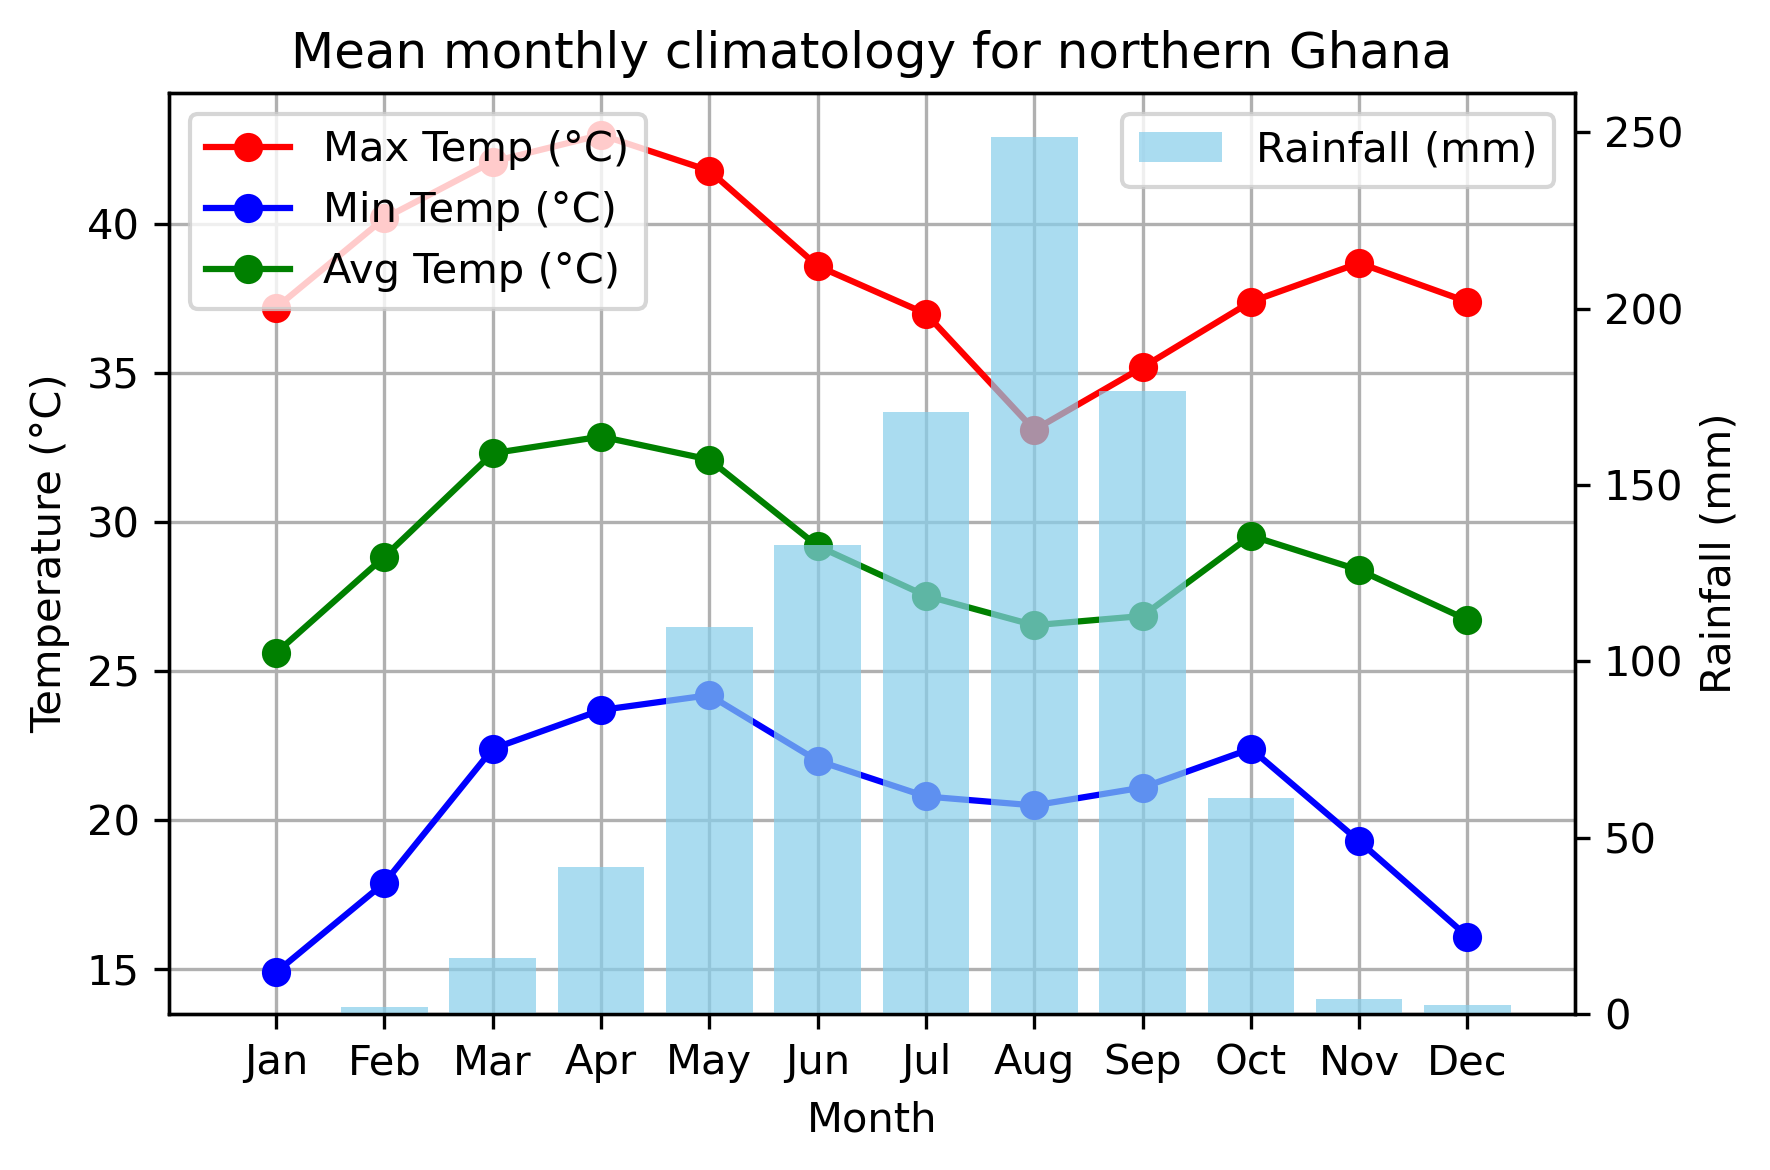

In [8]:
# Calculate monthly climatology for temperature
monthly_stats = df.groupby('month').agg(
    max_temp=('temp', 'max'),
    min_temp=('temp', 'min'),
    avg_temp=('temp', 'mean'),
    avg_humidity=('humidity', 'mean')
).reset_index()

# Add rainfall data to the monthly stats DataFrame
monthly_stats['Rainfall (mm)'] = rainfall_mm
monthly_stats['Month Name'] = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

# Plot temperatures
ax1.plot(monthly_stats['Month Name'], monthly_stats['max_temp'], label="Max Temp (°C)", color="red", marker="o")
ax1.plot(monthly_stats['Month Name'], monthly_stats['min_temp'], label="Min Temp (°C)", color="blue", marker="o")
ax1.plot(monthly_stats['Month Name'], monthly_stats['avg_temp'], label="Avg Temp (°C)", color="green", marker="o")
ax1.set_xlabel("Month")
ax1.set_ylabel("Temperature (°C)")
ax1.legend(loc="upper left")
ax1.grid()

# Create a secondary y-axis for rainfall
ax2 = ax1.twinx()
ax2.bar(monthly_stats['Month Name'], monthly_stats['Rainfall (mm)'], label="Rainfall (mm)", color="skyblue", alpha=0.7)
#ax2.plot(monthly_stats['Month Name'], monthly_stats['avg_humidity'], label="Avg Humidity (%)", color="purple", marker="s", linestyle="--")
ax2.set_ylabel("Rainfall (mm)")
ax2.legend(loc="upper right")

plt.title("Mean monthly climatology for northern Ghana")
plt.tight_layout()
plt.show()


Plot of the average sunshine duration for the two seasons

Average Sunshine Hours during Rainy Season: 6.74 hours
Average Sunshine Hours during Dry Season: 8.63 hours


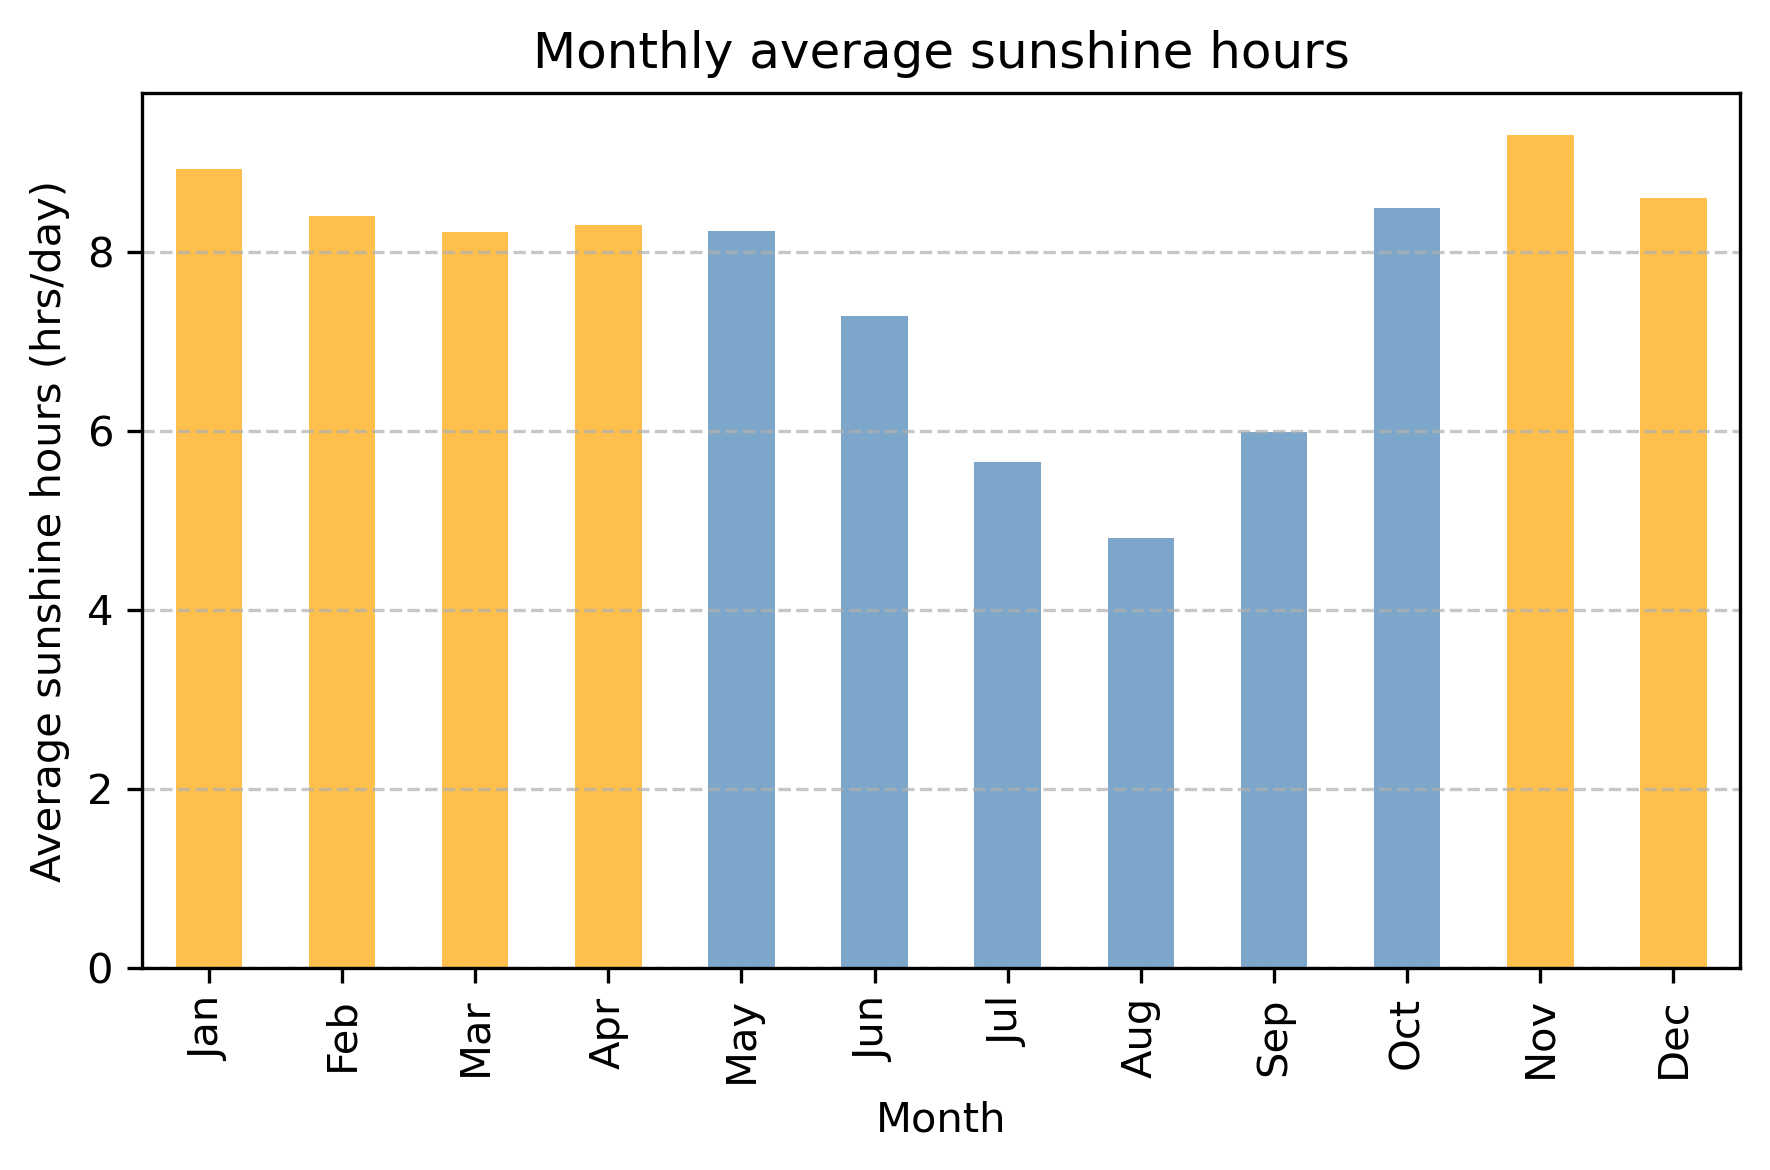

In [9]:
# Convert sunshine duration from minutes per hour to total hours per day
df['daily_sunshine_hours'] = df.groupby(['year', 'month', 'day'])['sunshine_duration'].transform('sum') / 60  # Sum for each day, convert to hours

# Define rainy and dry season masks
rainy_season = df['month'].between(5, 10)  # May to October
dry_season = ~rainy_season  # All other months

# Calculate seasonal averages for sunshine hours
rainy_avg_sun_hours = df.loc[rainy_season].groupby(['year', 'month', 'day'])['daily_sunshine_hours'].mean().mean()
dry_avg_sun_hours = df.loc[dry_season].groupby(['year', 'month', 'day'])['daily_sunshine_hours'].mean().mean()

# Display results
print(f"Average Sunshine Hours during Rainy Season: {rainy_avg_sun_hours:.2f} hours")
print(f"Average Sunshine Hours during Dry Season: {dry_avg_sun_hours:.2f} hours")

# Calculate mean daily sunshine hours for each month
df['month_name'] = df['month'].apply(lambda x: ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"][x - 1])
monthly_sunshine = df.groupby('month_name')['daily_sunshine_hours'].mean()

# Sort months for proper order
monthly_sunshine = monthly_sunshine.reindex(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                             "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
colors = ['orange' if month in ["Nov", "Dec", "Jan", "Feb", "Mar", "Apr"] else 'steelblue' for month in monthly_sunshine.index]
# Plot
plt.figure(figsize=(6, 4), dpi=300)
monthly_sunshine.plot(kind='bar', color=colors, alpha=0.7)
plt.title('Monthly average sunshine hours')
plt.xlabel('Month')
plt.ylabel('Average sunshine hours (hrs/day)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Plot of the peak sun hours for each month

Average Peak Sun Hours during Rainy Season: 5.85 hours
Average Peak Sun Hours during Dry Season: 6.05 hours
Day with the lowest Peak Sun Hours: 2005-09-01
Lowest Peak Sun Hours: 1.16 hours/day


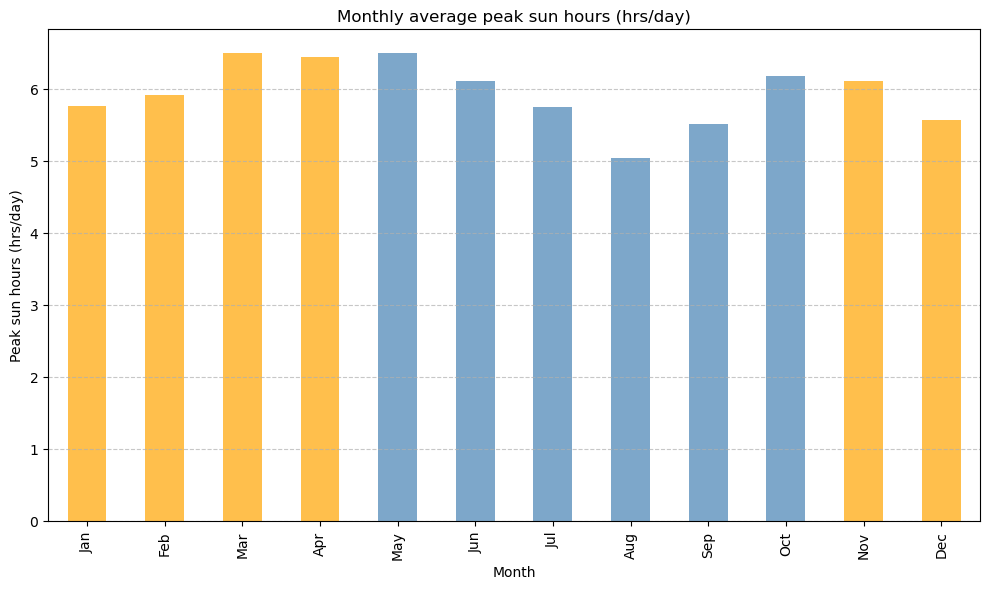

In [10]:
# Calculate daily total solar energy (GRH) in Wh/m² and daily peak sun hours
df['daily_GRH'] = df.groupby(['year', 'month', 'day'])['GRH'].transform('sum')  # Total daily GRH
df['daily_peak_sun_hours'] = df['daily_GRH'] / 1000  # Convert to Peak Sun Hours (hrs/day)


# Calculate seasonal averages for peak sun hours
rainy_avg_peak_sun_hours = df.loc[rainy_season].groupby(['year', 'month', 'day'])['daily_peak_sun_hours'].mean().mean()
dry_avg_peak_sun_hours = df.loc[dry_season].groupby(['year', 'month', 'day'])['daily_peak_sun_hours'].mean().mean()

# Display results
print(f"Average Peak Sun Hours during Rainy Season: {rainy_avg_peak_sun_hours:.2f} hours")
print(f"Average Peak Sun Hours during Dry Season: {dry_avg_peak_sun_hours:.2f} hours")
# Find the day with the lowest peak sun hours
lowest_peak_sun_hours_day = df.loc[df['daily_peak_sun_hours'].idxmin(), ['year', 'month', 'day', 'daily_peak_sun_hours']]

# Display the result
print(f"Day with the lowest Peak Sun Hours: {int(lowest_peak_sun_hours_day['year'])}-{int(lowest_peak_sun_hours_day['month']):02d}-{int(lowest_peak_sun_hours_day['day']):02d}")
print(f"Lowest Peak Sun Hours: {lowest_peak_sun_hours_day['daily_peak_sun_hours']:.2f} hours/day")

# Calculate mean daily peak sun hours for each month
df['month_name'] = df['month'].apply(lambda x: ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"][x - 1])
monthly_peak_sun_hours = df.groupby('month_name')['daily_peak_sun_hours'].mean()

# Sort months for proper order
monthly_peak_sun_hours = monthly_peak_sun_hours.reindex(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                                         "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
# Color coding for seasons
colors = ['orange' if month in ["Nov", "Dec", "Jan", "Feb", "Mar", "Apr"] else 'steelblue' for month in monthly_peak_sun_hours.index]

# Plot
plt.figure(figsize=(10, 6))
monthly_peak_sun_hours.plot(kind='bar', color=colors, alpha=0.7)
plt.title('Monthly average peak sun hours (hrs/day)')
plt.xlabel('Month')
plt.ylabel('Peak sun hours (hrs/day)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
